Finding Dominant Color Names from Color Space Coordinates and Images
=========================================

![](jupysmug.png)

## Let's install some software.

This notebook will explore various techniques for analyzing the contents of digital images
and computing:

1.  Color names from RGB, HSL and LAB color space coordinates.

2.  Finding a color "nearest" a preset pallette of colors.

3.  Computing an image's dominant color and returning a "nearest" color name.

To do this it may be necessary to install a number of packages. 
The following install commands will gather required packages.

In [8]:
!cd \anaconda3
!python -m pip install webcolors

In [19]:
!cd \anaconda3
!python -m pip install Pillow

## Using `webcolors` to Reverse Color Code.

After installing `webcolors` test it with this code snippet from [Stack Overflow](https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python).

In [3]:
import webcolors

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

requested_colour = (119, 172, 152)
actual_name, closest_name = get_colour_name(requested_colour)

print("Actual colour name:", actual_name, ", closest colour name:", closest_name)

Actual colour name: None , closest colour name: cadetblue


In [4]:
rgb0 = (0,0,0)
rgb1 = (255,255,255)
rgb2 = (255,0,0)
rgb3 = (0,255,0)
rgb4 = (0,0,255)

print(get_colour_name(rgb0))
print(get_colour_name(rgb1))
print(get_colour_name(rgb2))
print(get_colour_name(rgb3))
print(get_colour_name(rgb4))

('black', 'black')
('white', 'white')
('red', 'red')
('lime', 'lime')
('blue', 'blue')


## Generate Some Random Colors

In [5]:
from random import randint
print(randint(0, 255))

197


In [6]:
for a,b in 25 * [(0,255)]:
    rgb = (randint(a,b), randint(a,b), randint(a,b))
    print(get_colour_name(rgb)[-1])

purple
maroon
lawngreen
black
mediumorchid
lightpink
lightseagreen
darkolivegreen
darkslateblue
limegreen
darkgrey
crimson
tan
sienna
orangered
orangered
mediumorchid
brown
darkkhaki
mediumspringgreen
lightslategrey
darkorchid
peru
gainsboro
greenyellow


## First Dominant Color Calculation

After installing Pillow and making some minor code edits it's possible to 
run this [algorithm from Stack Overflow](https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image).

In [7]:
import struct
from PIL import Image
import numpy as np
import scipy
import scipy.misc
import scipy.cluster

In [119]:
NUM_CLUSTERS = 8

print('reading image')
#im = Image.open('C:/SmugMirror/Themes/Manipulations/ImageHacking/5NB7dXP-1f-green-gray-dragon-eggs.jpg')
im = Image.open('C:/SmugMirror/Themes/Manipulations/ImageHacking/hjbftwN-1-your-grainy-hell-awaits-[409595101].jpg')

#im = im.resize((300, 300))      # optional, to reduce time
ar = np.asarray(im)
shape = ar.shape
ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)

print('finding clusters')
codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
print ('cluster centres:\n', codes)

vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

index_max = scipy.argmax(counts)                    # find most frequent
peak = codes[index_max]
print('peak', peak)
#colour = ''.join(chr(int(c)) for c in peak).encode('hex')
#colour = ''.join(chr(int(c)) for c in peak) 
#print('most frequent is %s (#%s)' % (peak, colour))

reading image
finding clusters
cluster centres:
 [[  12.99251504    6.4571174    10.80396525]
 [ 241.16922273  223.48057763  133.13119893]
 [ 244.28118656  156.67245658   13.14318746]
 [  84.05236929   45.3901512    46.11842216]
 [ 233.8723991    22.25871146    9.93599064]
 [ 131.93473151  112.46302658  132.58090761]
 [ 241.98930548   97.09556675   16.83597588]
 [ 244.57441161  222.03048133   53.08808176]]
peak [ 241.16922273  223.48057763  133.13119893]


In [120]:
for color in codes:
    color_name = get_colour_name(color)[-1]
    print(color_name) 
    patch = Image.new("RGB", (100, 30), color_name)
    display(patch)   
    
print('peak color')
peak_color = get_colour_name(peak)[-1]
print(peak_color)
pc = Image.new("RGB", (100, 30), peak_color)
display(pc)     

black


khaki


orange


darkslategrey


red


grey


orangered


gold


peak color
khaki


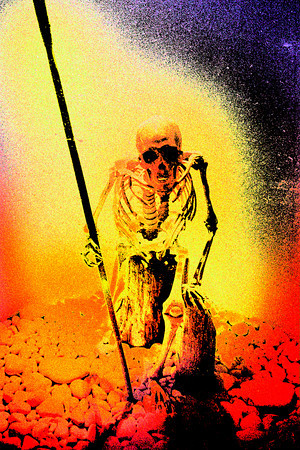

In [115]:
display(im)

In [116]:
print(im)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x450 at 0x1E93AD42B0>


## Second Dominant Color Calculation

This algorithm, due to [Charlies Leifer](https://charlesleifer.com/blog/using-python-and-k-means-to-find-the-dominant-colors-in-images/), also computes dominant colors.

In [11]:
from collections import namedtuple
from math import sqrt
import random
from PIL import Image
    
#try:
#    import Image
#except ImportError:
#    from PIL import Image

Point = namedtuple('Point', ('coords', 'n', 'ct'))
Cluster = namedtuple('Cluster', ('points', 'center', 'n'))

def get_points(img):
    points = []
    w, h = img.size
    for count, color in img.getcolors(w * h):
        points.append(Point(color, 3, count))
    return points

rtoh = lambda rgb: '#%s' % ''.join(('%02x' % p for p in rgb))

def colorz(filename, n=3):
    img = Image.open(filename)
    img.thumbnail((200, 200))
    w, h = img.size

    points = get_points(img)
    clusters = kmeans(points, n, 1)
    rgbs = [map(int, c.center.coords) for c in clusters]
    return map(rtoh, rgbs)

def euclidean(p1, p2):
    return sqrt(sum([
        (p1.coords[i] - p2.coords[i]) ** 2 for i in range(p1.n)
    ]))

def calculate_center(points, n):
    vals = [0.0 for i in range(n)]
    plen = 0
    for p in points:
        plen += p.ct
        for i in range(n):
            vals[i] += (p.coords[i] * p.ct)
    return Point([(v / plen) for v in vals], n, 1)

def kmeans(points, k, min_diff):
    clusters = [Cluster([p], p, p.n) for p in random.sample(points, k)]

    while 1:
        plists = [[] for i in range(k)]

        for p in points:
            smallest_distance = float('Inf')
            for i in range(k):
                distance = euclidean(p, clusters[i].center)
                if distance < smallest_distance:
                    smallest_distance = distance
                    idx = i
            plists[idx].append(p)

        diff = 0
        for i in range(k):
            old = clusters[i]
            center = calculate_center(plists[i], old.n)
            new = Cluster(plists[i], center, old.n)
            clusters[i] = new
            diff = max(diff, euclidean(old.center, new.center))

        if diff < min_diff:
            break

    return clusters

In [12]:
dmap = colorz('C:/SmugMirror/Themes/Manipulations/ImageHacking/5NB7dXP-1f-green-gray-dragon-eggs.jpg')

In [13]:
list(dmap)

['#5e8529', '#212c11', '#9cb77a']

In [14]:
rgb = webcolors.hex_to_rgb('#5f872a')
get_colour_name(rgb)

(None, 'olivedrab')

In [121]:
# "nearest" named dominant colors
dmap = colorz('C:/SmugMirror/Themes/Manipulations/ImageHacking/5NB7dXP-1f-green-gray-dragon-eggs.jpg', n=8)
for hxc in list(dmap):
    rgb = webcolors.hex_to_rgb(hxc)
    color_name = get_colour_name(rgb)[-1]
    print(color_name)  
    im = Image.new("RGB", (100, 30), color_name)
    display(im)   

olivedrab


yellowgreen


silver


grey


darkolivegreen


darkslategrey


darkolivegreen


black


In [16]:
im2 = Image.open('C:/SmugMirror/Themes/Manipulations/ImageHacking/hjbftwN-1-your-grainy-hell-awaits-[409595101].jpg')

In [17]:
print(im2.size)

(300, 450)


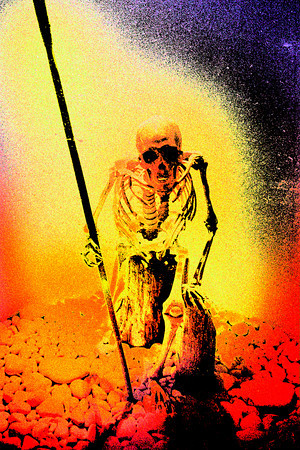

In [18]:
display(im2)

In [122]:
# "nearest" named dominant colors
dmap = colorz('C:/SmugMirror/Themes/Manipulations/ImageHacking/hjbftwN-1-your-grainy-hell-awaits-[409595101].jpg',n=8)
for hxc in list(dmap):
    rgb = webcolors.hex_to_rgb(hxc)
    color_name = get_colour_name(rgb)[-1]
    print(color_name)  
    im = Image.new("RGB", (100, 30), color_name)
    display(im)

black


khaki


dimgrey


darkorange


orangered


gold


burlywood


saddlebrown


## Third Dominant Color Calculation

This algorithm, due to [Srijan Anand](https://github.com/srijannnd/Dominant-Color-Extraction-Dominance-and-Recoloring), is another variation on *kmeans*. The original notebook code required
some changes as `cv2` is not currently available for Python 3.6 Win64 Anaconda systems. It can be replaced
with `PIL`.

In [20]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
#import cv2
from sklearn.cluster import KMeans

In [127]:
# use PIL images they default to RGB
#image = cv2.imread(".\img.jpg")
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.open('C:/SmugMirror/Themes/Manipulations/ImageHacking/5NB7dXP-1f-green-gray-dragon-eggs.jpg')
print(image.size)
r, c = image.size
out_r = 120
print((int(out_r*float(c)/r), out_r))
print(type(image))

(600, 450)
(90, 120)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


(450, 600, 3)
<class 'numpy.ndarray'>
(270000, 3)
(450, 600, 3)


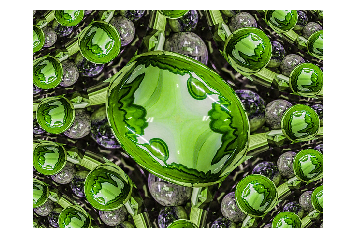

In [128]:
ar = np.asarray(image)
shape = ar.shape
print(shape)
pixels = ar.reshape((-1, 3))
print(type(pixels))
print(pixels.shape)
print(ar.shape)
plt.axis("off")
plt.imshow(ar)

In [129]:
km = KMeans(n_clusters=8)
km.fit(pixels)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [130]:
colors = np.asarray(km.cluster_centers_, dtype='uint8')
print(colors)

[[ 91 154   8]
 [135 135 123]
 [ 18  24  10]
 [198 213 185]
 [161 201 109]
 [ 48  78  16]
 [124 170  63]
 [ 89  97  68]]


In [131]:
# names of "nearest" color names
for color in colors:
    color_name = get_colour_name(color)[-1]
    print(color_name)  
    im = Image.new("RGB", (100, 30), color_name)
    display(im)

olivedrab


grey


black


silver


darkkhaki


darkgreen


olivedrab


darkolivegreen


In [132]:
percentage = np.asarray(np.unique(km.labels_, return_counts = True)[1], dtype='float32')
percentage = percentage/pixels.shape[0]
percentage

array([ 0.13512222,  0.07246667,  0.26118889,  0.07584074,  0.10036667,
        0.15484815,  0.1089    ,  0.09126667])

##  Dominant Colors for Third Calculation

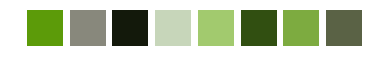

In [133]:
plt.figure(0)
for ix in range(colors.shape[0]):
    patch = np.ones((20, 20, 3))
    patch[:, :, :] = 255 - colors[ix]
    plt.subplot(1, colors.shape[0], ix+1)
    plt.axis('off')
    plt.imshow(patch)
plt.show()

In [134]:
dom = [[percentage[ix], colors[ix]] for ix in range(km.n_clusters)]
dominance = sorted(dom, key=lambda x:x[0], reverse=True)

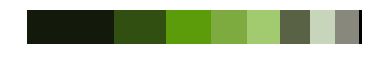

In [135]:
plt.figure(0)
plt.axis('off')

patch = np.zeros((50, 500, 3))

start = 0
for cx in range(km.n_clusters):
    width = int(dominance[cx][0] * patch.shape[1])
    end = start + width
    patch[:, start:end, :] = 255 - dominance[cx][1]
    start = end
plt.imshow(patch)
plt.show()

In [89]:
for px in range(pixels.shape[0]):
    for ix in range(colors.shape[0]):
        pixels[px] =colors[km.labels_[px]]

ValueError: assignment destination is read-only

In [140]:
img = pixels.reshape(out_r, -1, 3)
#img = pixels
print(img.shape)

(120, 2250, 3)


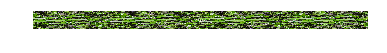

In [141]:
plt.axis("off")
plt.imshow(img)